# Setting up working environment

In [ ]:
import torch

# Setting up working environment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [2]:
# setting up working directory

content_path = "/home/jia/Desktop/MSc_Project/m2integrator"
data_path = "/home/jia/Desktop/MSc_Project/m2integrator/SG-Net-data"


In [ ]:
# Check GPU cache

!pip install GPUtil


import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()           

# Import Data

In [ ]:
import scipy.io
import numpy as np

# Load .mat file
# Feature vector 1
roi_35_o = scipy.io.loadmat(f'{data_path}/morph_thickness_data_35_avg.mat')['morph_thickness_data_35_avg'][0:100]

# roi_35 = scipy.io.loadmat(f'{data_path}/morph_thickness_data_35_avg.mat')['morph_thickness_data_35_avg']
shape1 = roi_35_o.shape
print(f'shape of dataset1 {shape1}')
# Feature vector2
roi_160 = scipy.io.loadmat(f'{data_path}/func_data_160.mat')['LR'][0:100]

# roi_160 = scipy.io.loadmat(f'{data_path}/func_data_160.mat')['LR']
shape2 = roi_160.shape
print(f'shape of dataset2 {shape2}')
# Feature vector3
roi_268 = scipy.io.loadmat(f'{data_path}/func_data_268.mat')['HR'][0:100]

# roi_268 = scipy.io.loadmat(f'{data_path}/func_data_268.mat')['HR']
shape3 = roi_268.shape
print(f'shape of dataset3 {shape3}')

print(type(roi_35_o))  

## preprocess data

By visualising the dataset, we found mophological feature vectors were vectorized  horizontally, but functional feature vectors were 
vectorized vertically. Therefore, we firstly formallize all the data in a **vertically-verctorized** form.

- Morphological data : roi_35
- Functional data: roi_160 and roi_268

In [5]:
import helper

roi_35 = []
for data in roi_35_o:
    data = helper.pre_horizontal_antiVectorize(data, 35)
    data = helper.pre_vertical_vectorize(data)
    roi_35.append(data)

roi_35 = np.array(roi_35)
    
shape1 = roi_35.shape
print(f'shape of dataset1 {shape1}')

shape of dataset1 (100, 595)


It is worth to notice that we 'diacard' all negative values in fucntional MRI, which means set all negative values to zero.

In [6]:

roi_160 = np.clip(roi_160, a_min=0, a_max=None)
roi_268 = np.clip(roi_268, a_min=0, a_max=None)

In [ ]:
from demo import k_fold_train

final_reults, recon_results, topo_results = k_fold_train(roi_35, roi_160, roi_268)



## Visualise evaluation metric

In [ ]:
import matplotlib.pyplot as plt
def plot_final_eval_metric(plotdata):
    plotdata.plot(kind="bar",figsize=(15, 8))

    plt.title("Centeredness of CBT on test set")

    plt.ylabel("Frob distance between embedded MRIs and their CBT")

--------Local results---------
                     not federated  global federated  ablated federated
client1                   0.014893          0.020993           0.020738
client2                   0.014295          0.024208           0.023997
client3                   0.046020          0.021176           0.021107
global centeredness       0.161818          0.002876           0.002801
--------Recon results---------
         not federated  global federated  ablated federated
client1       0.844696          0.844508           0.844524
client2       0.152192          0.152099           0.152102
client3       0.181971          0.180175           0.180284
--------Topo results---------
         not federated  global federated  ablated federated
client1       0.000000          0.000000           0.000000
client2       0.204166          0.204111           0.204176
client3       0.193048          0.193105           0.193063


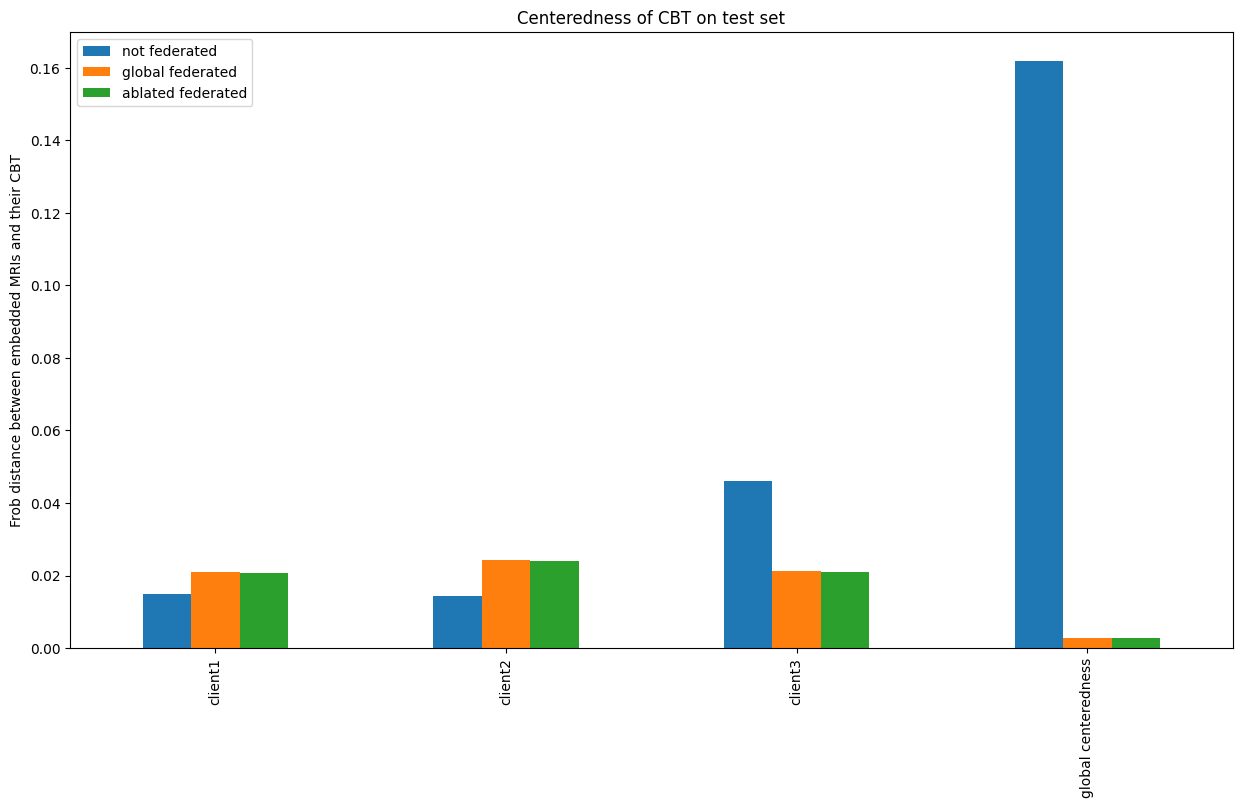

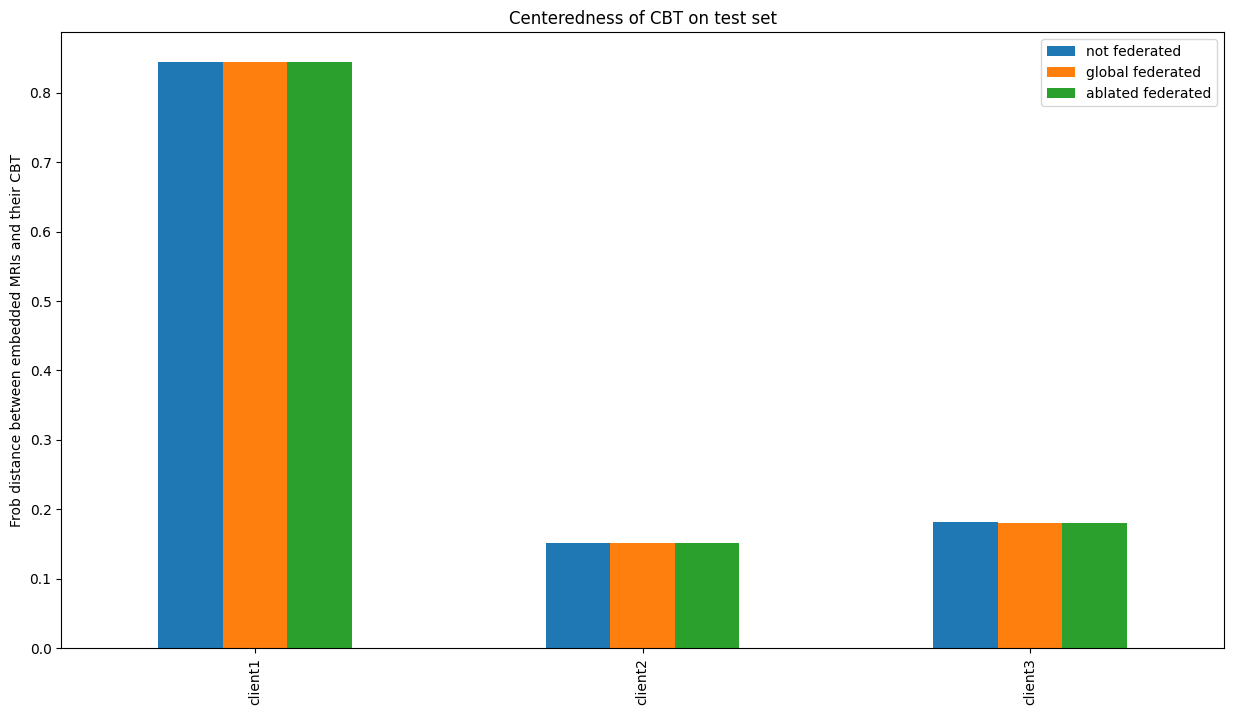

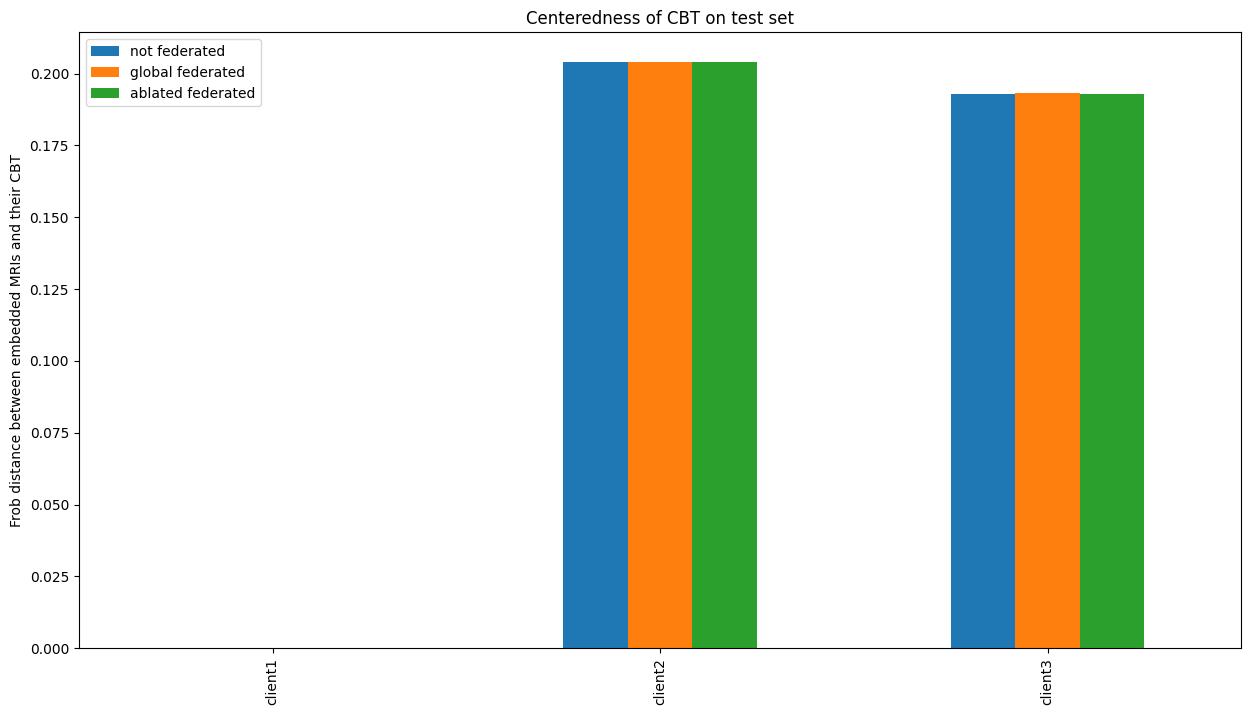

In [ ]:
from config import CONFIG

print("--------Local results---------")
print(final_reults)
print("--------Recon results---------")
print(recon_results)
print("--------Topo results---------")
print(topo_results)


plot_final_eval_metric(final_reults)

plot_final_eval_metric(recon_results)

plot_final_eval_metric(topo_results)

## Show CBTs

*********client 1   fold 0 *********


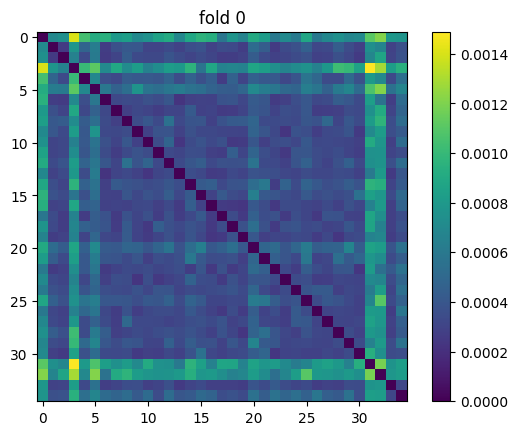

*********client 1   fold 1 *********


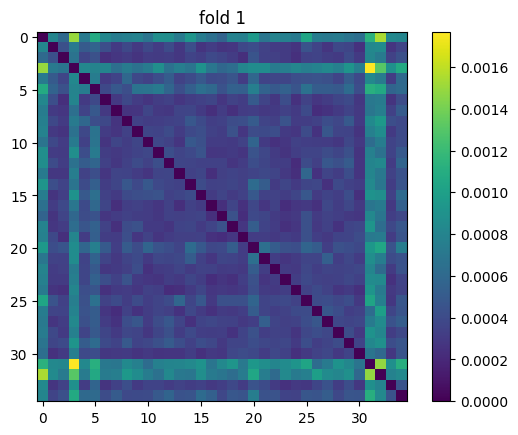

*********client 1   fold 2 *********


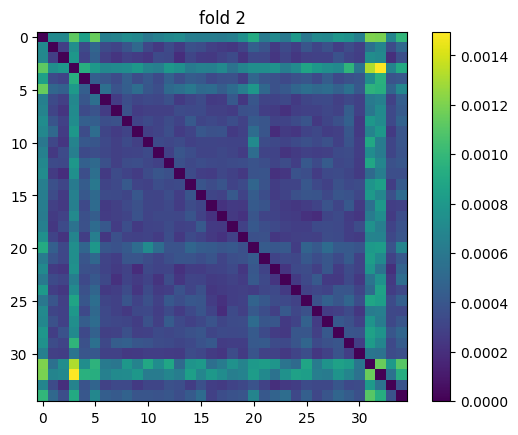

*********client 1   fold 3 *********


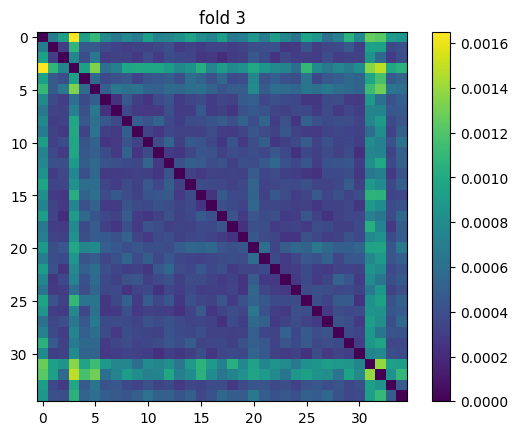

*********client 2   fold 0 *********


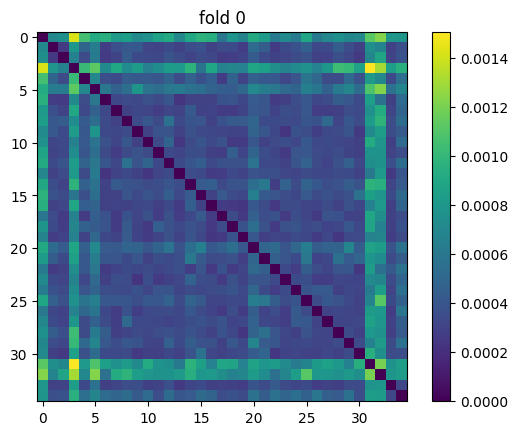

*********client 2   fold 1 *********


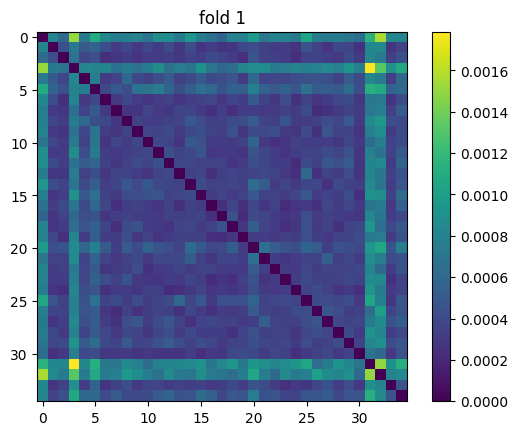

*********client 2   fold 2 *********


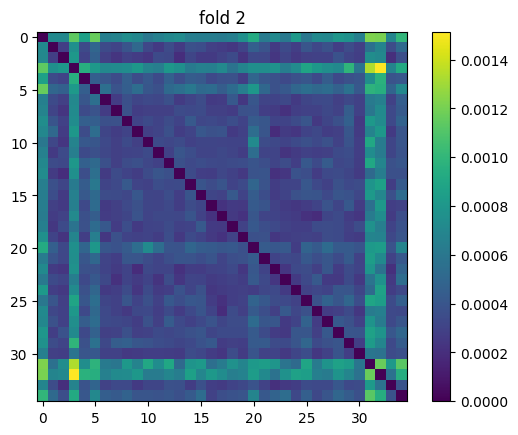

*********client 2   fold 3 *********


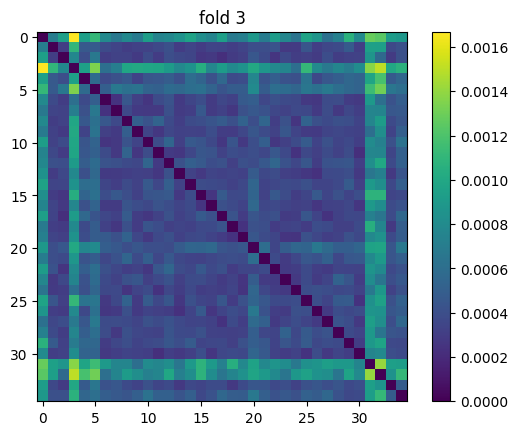

*********client 3   fold 0 *********


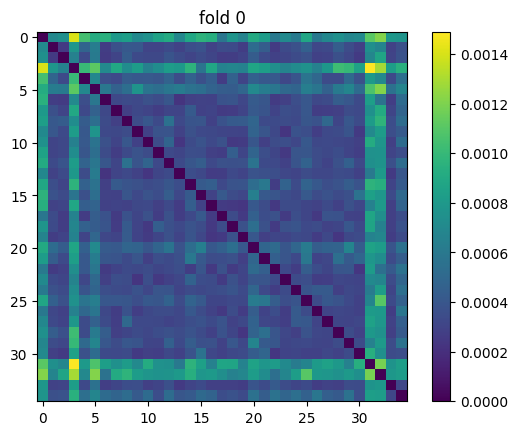

*********client 3   fold 1 *********


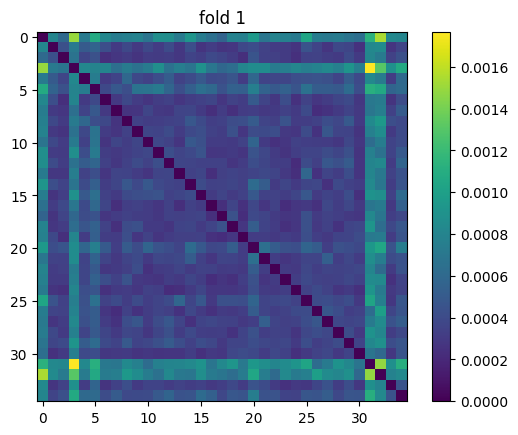

*********client 3   fold 2 *********


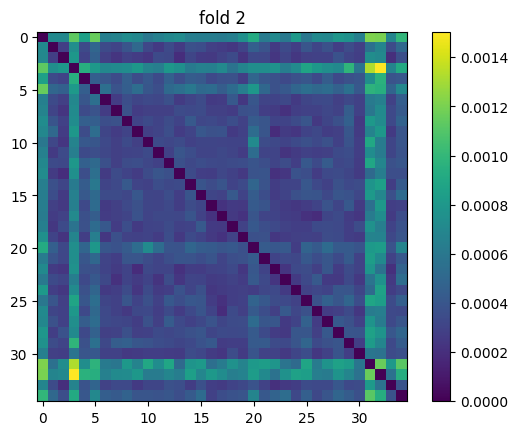

*********client 3   fold 3 *********


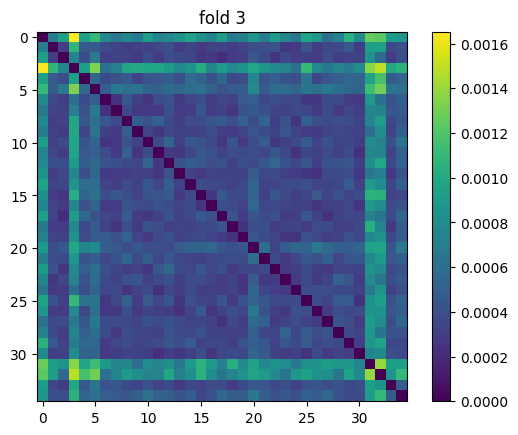

In [ ]:
from helper import show_image
import numpy as np
from config import CONFIG
import os

sampling_method = CONFIG['sampling_method']
model_name = CONFIG['model_name']

save_path = f'./output/{sampling_method}/{model_name}/cbt_globalfed'
if not os.path.exists(save_path):
    os.makedirs(save_path)
cbt_path = f'./output/{sampling_method}/{model_name}/global_fed'
for n in range(3):
    for i in range(4):
        print("*********client {}   fold {} *********".format(n+1, i))
        cbt = np.load(f'{cbt_path}/client{n+1}_cbts/fold{i}_cbt.npy')
        show_image(cbt, n+1, i, save_path)

## Plot training loss

In [ ]:

import matplotlib.pyplot as plt
def plot_client_training_log(client_name, loss_data_nofed, loss_data_fed, fold_num, sampling_method, save_path):
    print("********* {}   fold {} *********".format(client_name, fold_num))

    fig, axs = plt.subplots(1, 5, figsize = (20,4))
    for i, key in enumerate(["local centeredness", "reconstruction", "topology", "total local loss", "global centeredness loss"]):
        loss_fed = loss_data_fed[key]
        loss_nofed = loss_data_nofed[key]
        epoch = loss_data_fed["epoch"]
        axs[i].plot(epoch, loss_fed, 'tab:orange', label='Federated')  # Add label for federated loss
        axs[i].plot(epoch, loss_nofed, 'tab:green', label='Non-federated')  # Add label for non-federated loss
        axs[i].set(xlabel= 'epoch', ylabel= f'{key} loss')
        axs[i].set_title(f'{key} loss')
        axs[i].legend()  # Show the legend
    plt.suptitle(f'fold {fold_num} of {client_name} with {sampling_method} sampling on train set')
    plt.savefig(f'{save_path}/{client_name}_trainloss_fold{fold_num}')
    plt.show()

********* client1   fold 0 *********


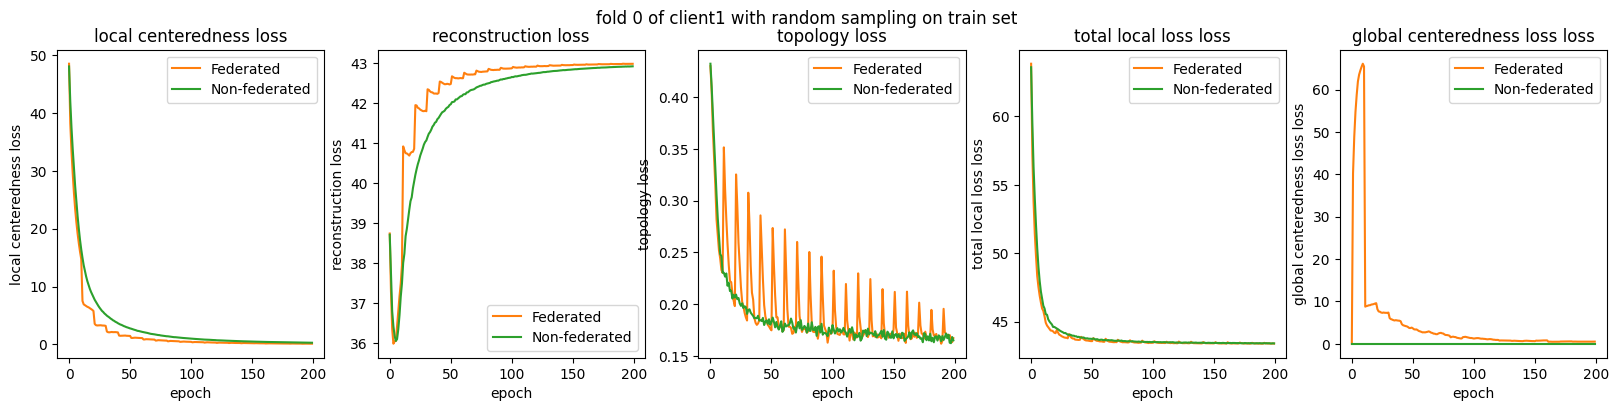

********* client1   fold 1 *********


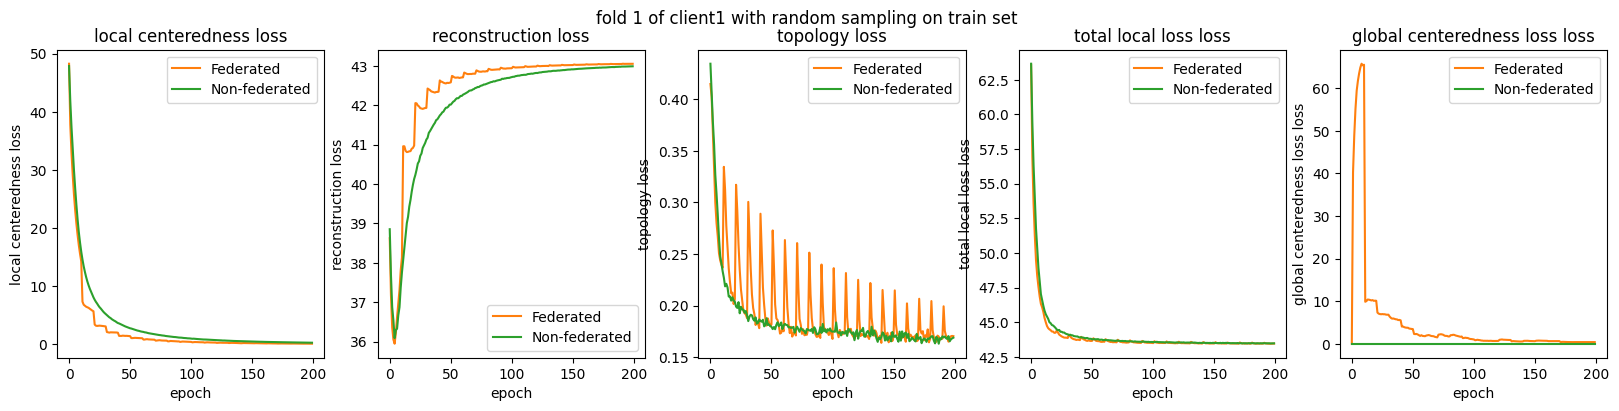

********* client1   fold 2 *********


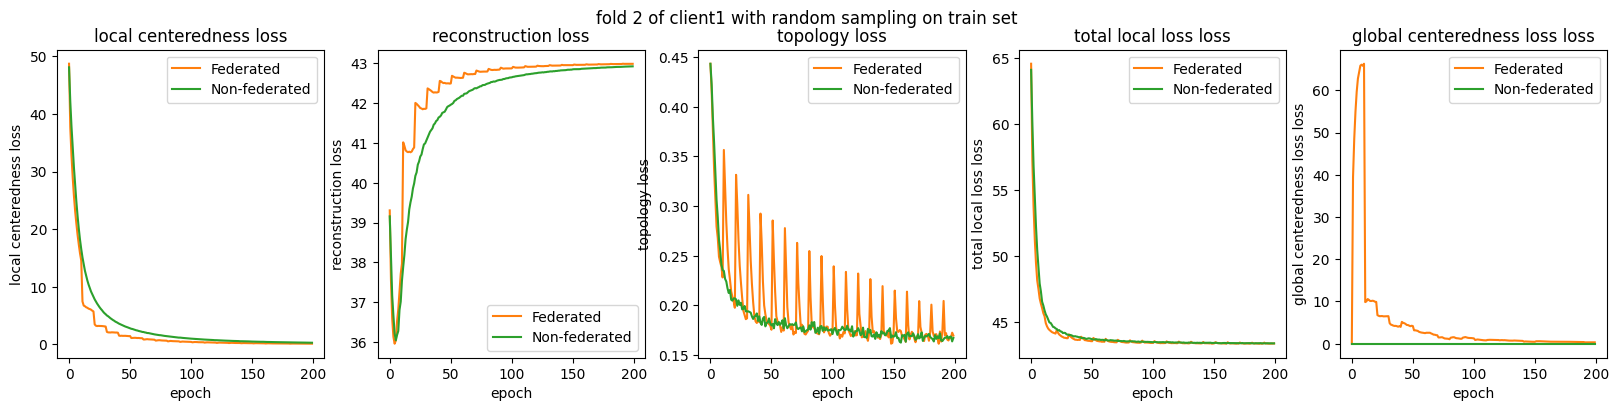

********* client1   fold 3 *********


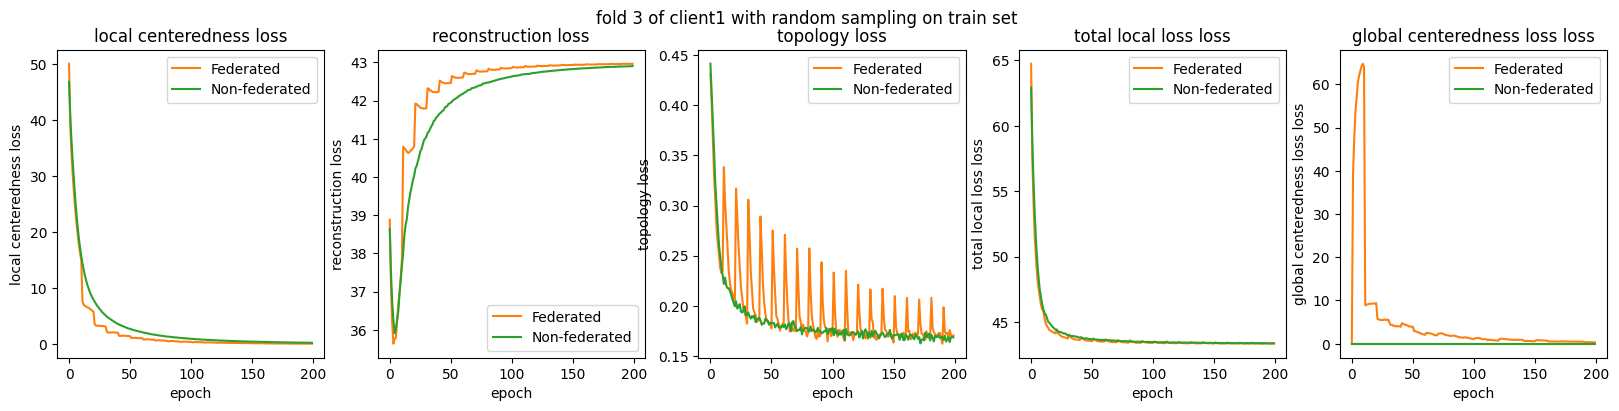

********* client2   fold 0 *********


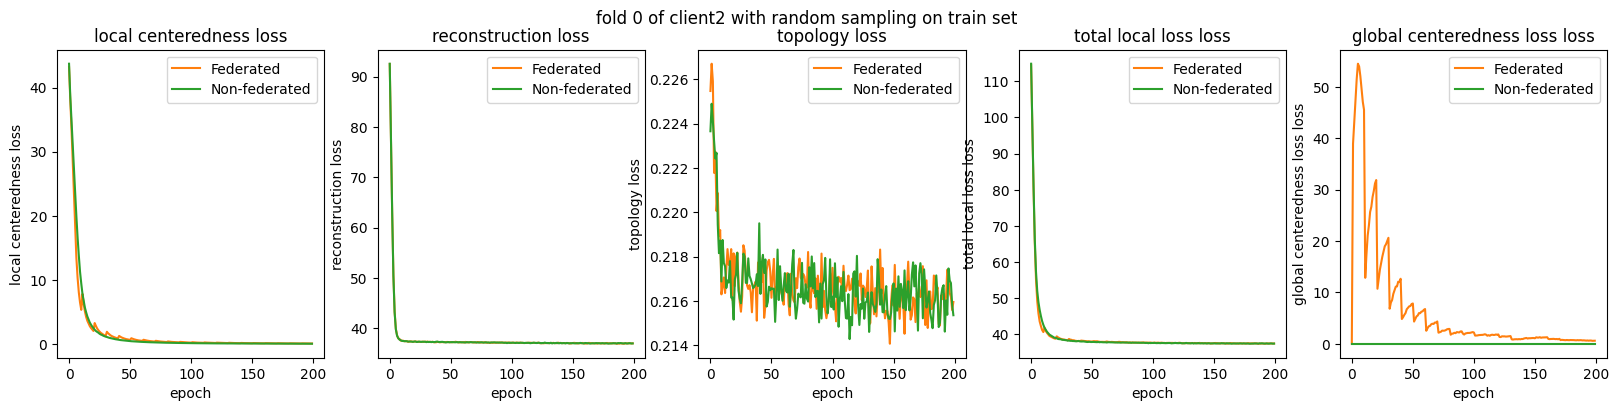

********* client2   fold 1 *********


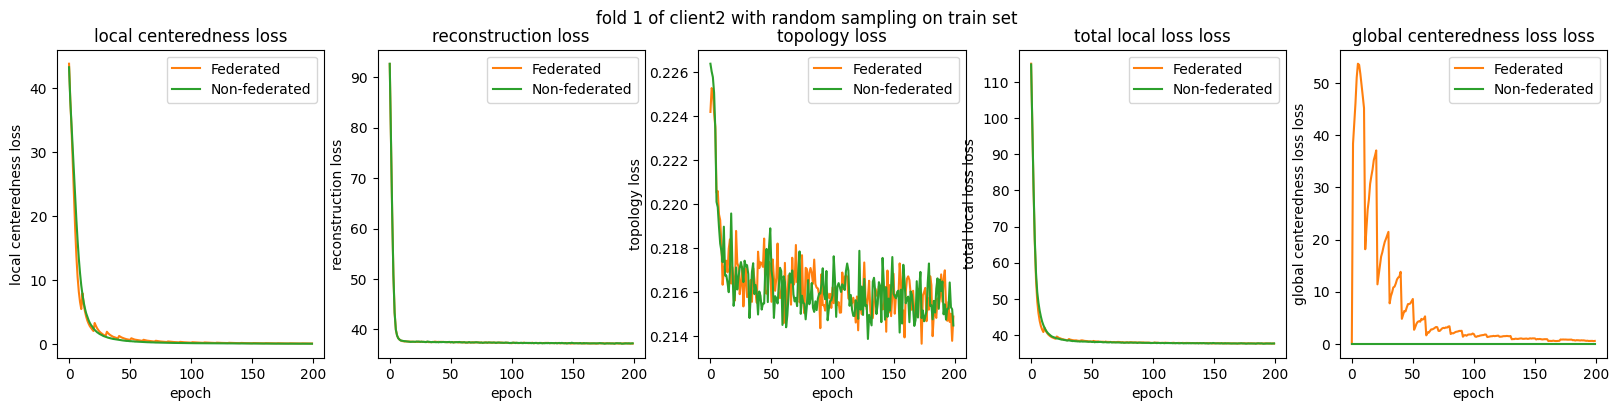

********* client2   fold 2 *********


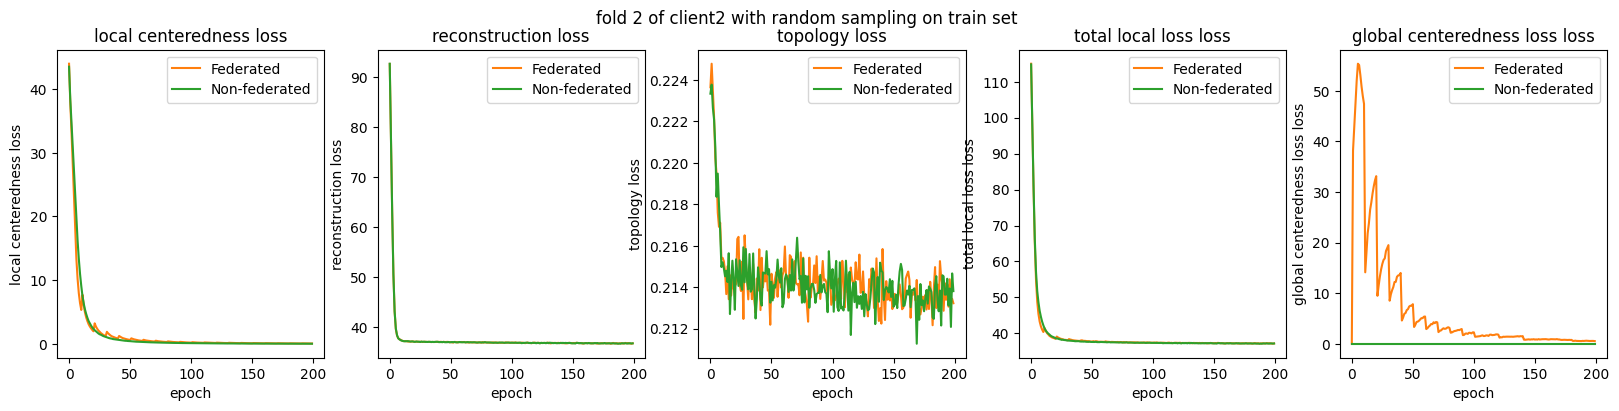

********* client2   fold 3 *********


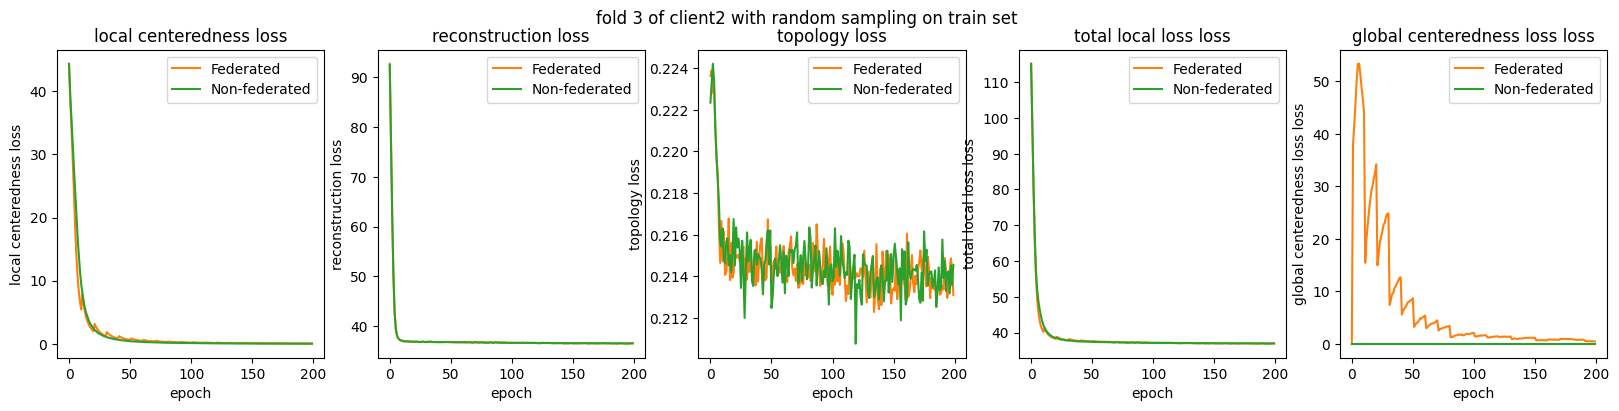

********* client3   fold 0 *********


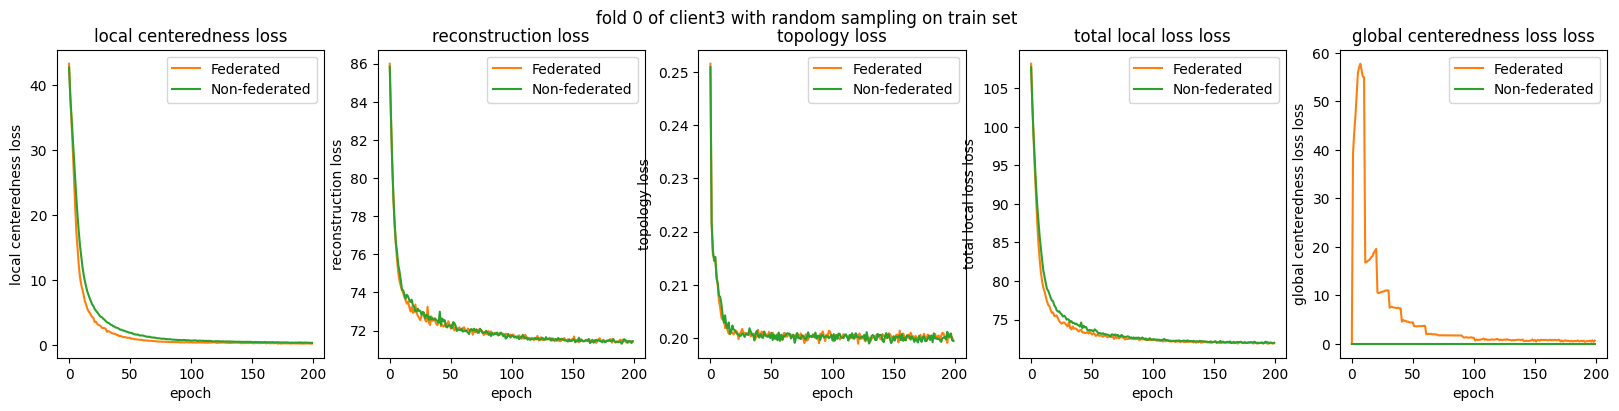

********* client3   fold 1 *********


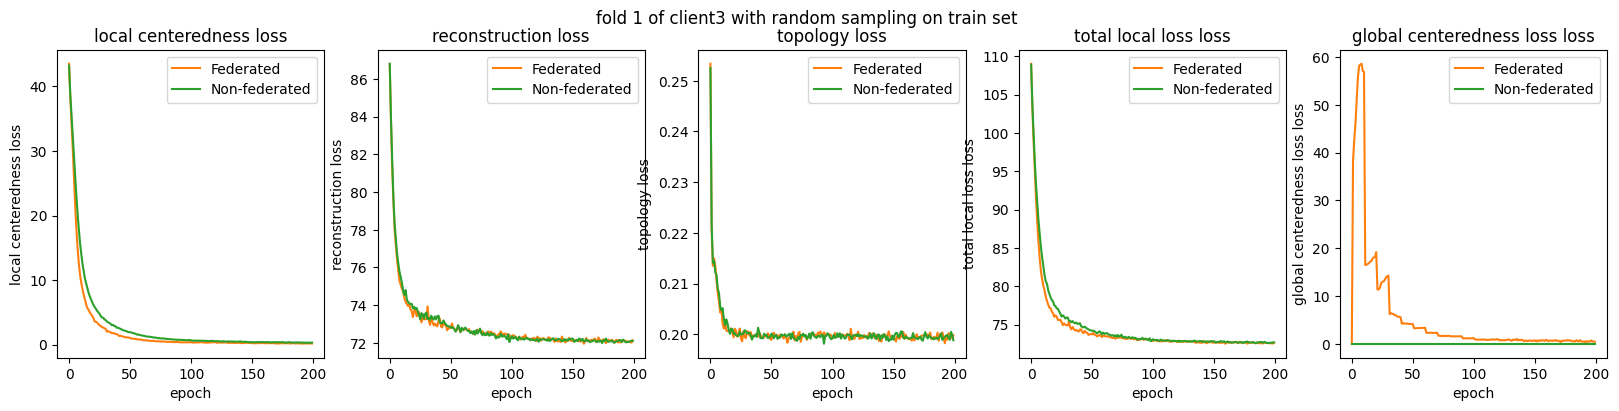

********* client3   fold 2 *********


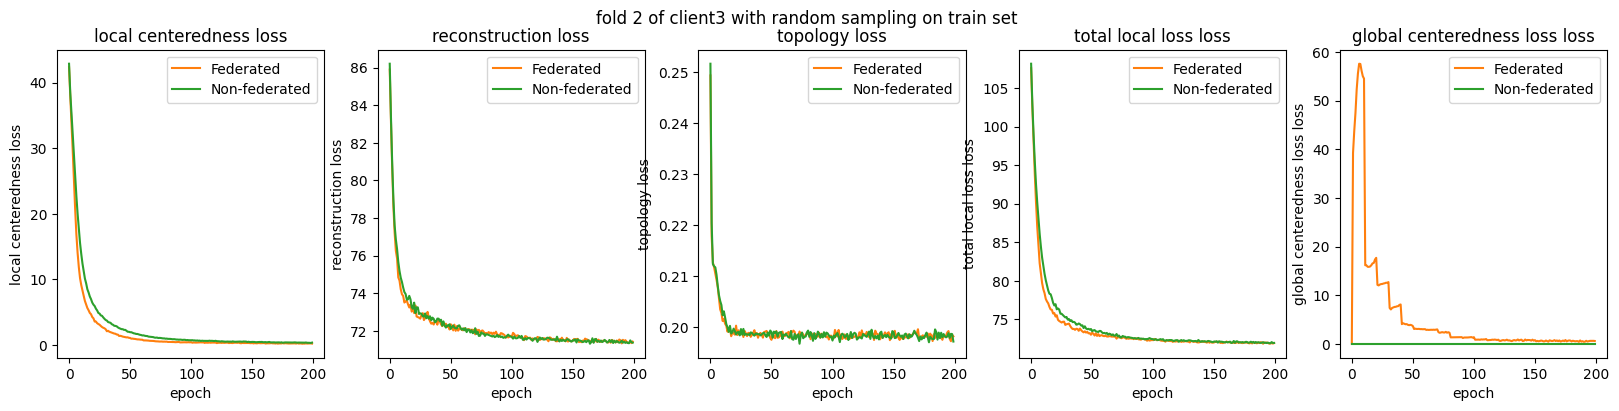

********* client3   fold 3 *********


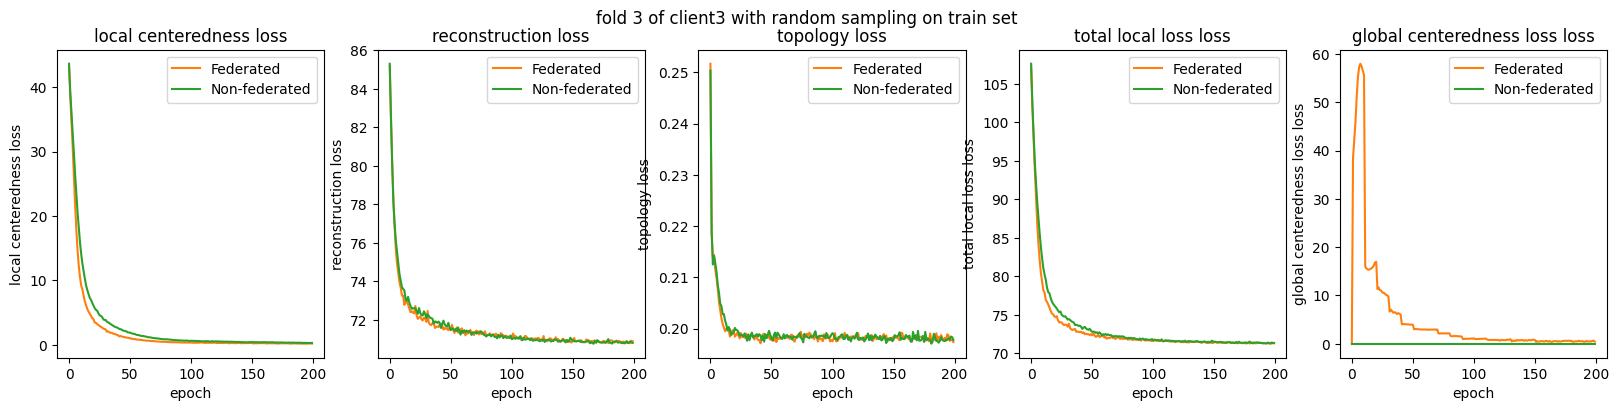

In [ ]:
import pickle
from config import CONFIG
import os

sampling_method = CONFIG['sampling_method']
model_name = CONFIG['model_name']
n_folds = CONFIG['n_folds']

save_path = f'./output/{sampling_method}/{model_name}/client_loss_plot'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for client in ['client1', 'client2', 'client3']:
    for n in range(n_folds):
        with open(f'./output/{sampling_method}/{model_name}/nofed/loss/fold{n}_client_loss_log.pkl', 'rb') as file:
            log_nofed = pickle.load(file)
        with open(f'./output/{sampling_method}/{model_name}/global_fed/loss/fold{n}_client_loss_log.pkl', 'rb') as file:
            log_fed = pickle.load(file)
        plot_client_training_log(client, log_nofed[client], log_fed[client], n, sampling_method, save_path)

## plot evaluation metric

In [28]:
import matplotlib.pyplot as plt
def plot_client_eval_log(client_name, eval_data_nofed, eval_data_fed, fold_num, sampling_method, save_path):
    print("********* {}   fold {} *********".format(client_name, fold_num))

    fig, axs = plt.subplots(1, 1, figsize = (6,4))
    for i, key in enumerate(["local_centeredness"]):
        loss_fed = eval_data_fed[key]
        loss_nofed = eval_data_nofed[key]
        epoch = eval_data_fed["epoch"]
        print(len(epoch))
        print(len(loss_fed))
        axs.plot(epoch, loss_fed, 'tab:orange', label='Federated')  # Add label for federated loss
        axs.plot(epoch, loss_nofed, 'tab:green', label='Non-federated')  # Add label for non-federated loss
        axs.set(xlabel= 'epoch', ylabel= f'{key} loss')
        axs.set_title(f'{key} loss')
        axs.legend()  # Show the legend
    plt.suptitle(f'fold {fold_num} of {client_name} with {sampling_method} sampling on train set')
    plt.savefig(f'{save_path}/{client_name}_trainloss_fold{fold_num}')
    plt.show()

In [ ]:
import pickle
from config import CONFIG
import os

sampling_method = CONFIG['sampling_method']
model_name = CONFIG['model_name']
n_folds = CONFIG['n_folds']

save_path = f'./output/{sampling_method}/{model_name}/client_eval_plot'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for client in ['client1', 'client2', 'client3']:
    for n in range(n_folds):
        with open(f'./output/{sampling_method}/{model_name}/nofed/eval/fold{n}_client_eval_log.pkl', 'rb') as file:
            log_nofed = pickle.load(file)
        with open(f'./output/{sampling_method}/{model_name}/fed/eval/fold{n}_client_eval_log.pkl', 'rb') as file:
            log_fed = pickle.load(file)
        plot_client_eval_log(client, log_nofed[client], log_fed[client], n, sampling_method, save_path)